In [1]:




import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report



In [5]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
df = pd.read_csv("xray_input.csv")
df.head()

,Image Index,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,-0.187979,0.043346,-0.005866,-0.180116,-0.216491,0.181554,0.053038,-0.242247,-0.196432,...,0,0,0,0,0,0,1,0,0,0
1,00000001_001.png,-0.173904,0.104313,-0.027356,0.061408,-0.213318,0.297480,0.328217,-0.221172,-0.119333,...,0,1,0,0,0,0,1,0,0,0
2,00000001_002.png,-0.156875,0.002193,-0.183765,0.010118,-0.242131,0.274381,-0.061397,0.085868,-0.178546,...,0,0,0,1,0,0,1,0,0,0
3,00000002_000.png,-0.197439,0.289834,-0.143378,0.238400,-0.159914,0.132197,-0.086083,-0.187805,-0.050839,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,-0.123684,-0.005224,-0.083841,0.031354,-0.202258,0.914344,0.074426,-0.222060,-0.199442,...,0,0,0,0,0,0,0,0,0,1


In [21]:


# Assuming df is your dataframe with features x0-x2048 and the 14 label columns
# Separate features and labels
X = df.filter(regex='^x\d+')
y = df[["Atelectasis", "Consolidation", "Infiltration", "Pneumothorax", "Edema",
       "Emphysema", "Fibrosis", "Effusion", "Pneumonia", "Pleural_Thickening",
       "Cardiomegaly", "Nodule", "Mass", "Hernia"]]

# Create a column indicating if all labels are 0 (no findings)
y['no_finding'] = (y.sum(axis=1) == 0).astype(int)

# Split the data first to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y.drop('no_finding', axis=1), 
    test_size=0.2, 
    random_state=42, 
    stratify=y['no_finding']
)

# Scale the data before applying PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA - try reducing to ~100-200 components to start
# You can adjust n_components based on your RAM constraints and the variance explained
n_components = 100  # Starting point, adjust as needed
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check explained variance to ensure we've captured enough information
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total explained variance with {n_components} components: {explained_variance:.4f}")

# Now proceed with your balanced sampling as before
no_findings = y_train.sum(axis=1) == 0
X_train_no_findings = X_train_pca[no_findings]

y_train_no_findings = y_train[no_findings]
X_train_findings = X_train_pca[~no_findings]
y_train_findings = y_train[~no_findings]

# Sample only a portion of the no-findings records
sample_size = int(len(X_train_no_findings) * 0.05)  # Adjust ratio as needed
indices = np.random.choice(len(X_train_no_findings), sample_size, replace=False)
X_train_no_findings_sampled = X_train_no_findings[indices]
y_train_no_findings_sampled = y_train_no_findings.iloc[indices]

# Combine the sampled no-findings with all findings samples
X_train_balanced = np.vstack([X_train_no_findings_sampled, X_train_findings])
y_train_balanced = pd.concat([y_train_no_findings_sampled, y_train_findings])


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/var/folders/5q/fmks3y_x73d1rdwpr7g2y9c40000gn/T/ipykernel_61833/3290264247.py:3: SyntaxWarning: invalid escape sequence '\d'
  X = df.filter(regex='^x\d+')
/var/folders/5q/fmks3y_x73d1rdwpr7g2y9c40000gn/T/ipykernel_61833/3290264247.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['no_finding'] = (y.sum(axis=1) == 0).astype(int)


Total explained variance with 100 components: 0.7999


In [22]:
X_train_balanced


array([[ 9.04101368e+00, -1.67271092e+00,  1.81884919e+00, ...,
         6.08618858e-01,  7.55722704e-03,  1.70770134e-02],
       [ 1.98795617e+01, -9.61303985e+00, -8.16642121e-01, ...,
         2.60334443e-01, -7.39803742e-01, -1.45892705e+00],
       [ 2.88719176e+01, -9.19336599e+00, -1.83663516e+01, ...,
         1.03321812e+00,  2.38960929e+00,  2.21570140e+00],
       ...,
       [-4.22392115e+00,  8.18450975e+00, -9.07167896e-01, ...,
        -1.68643287e+00, -1.38714688e+00, -9.43391533e-02],
       [-1.17175822e+01,  1.53355860e+01, -1.14901236e+01, ...,
        -2.28074792e+00, -1.31174074e+00,  1.73910727e+00],
       [ 1.03327133e+01, -7.85361759e+00,  9.00489929e+00, ...,
         5.31199018e-01,  2.04622045e+00, -4.64904208e-01]],
      shape=(43821, 100))

In [23]:
y_train_balanced

,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
109454,0,0,0,0,0,0,0,0,0,0,0,0,0,0
57193,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54404,0,0,0,0,0,0,0,0,0,0,0,0,0,0
70381,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24191,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39768,1,1,0,0,0,0,0,0,0,0,0,0,0,0
79030,1,1,1,0,0,0,1,1,0,0,0,0,1,0
103080,0,0,0,0,0,1,0,0,0,1,0,1,0,0
96763,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [26]:
!pip install seaborn

python(93993) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [24]:

# Train multi-label SVC with the reduced dimensionality data
svc = SVC(kernel='rbf', C=0.1, probability=True)
multi_svc = MultiOutputClassifier(svc, n_jobs=-1)
multi_svc.fit(X_train_balanced, y_train_balanced)
print("Finished Fit")

# Predict and evaluate
y_pred = multi_svc.predict(X_test_pca)

# Evaluate per class
for i, label in enumerate(y_train.columns):
    print(f"Classification report for {label}:")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))


python(81676) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81677) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81678) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81679) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81680) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81681) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81682) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81683) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(81687) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Finished Fit


python(91465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91468) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91469) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91470) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91471) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91472) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91473) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(91474) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Classification report for Atelectasis:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     20114
           1       0.00      0.00      0.00      2310

    accuracy                           0.90     22424
   macro avg       0.45      0.50      0.47     22424
weighted avg       0.80      0.90      0.85     22424

Classification report for Consolidation:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21518
           1       0.00      0.00      0.00       906

    accuracy                           0.96     22424
   macro avg       0.48      0.50      0.49     22424
weighted avg       0.92      0.96      0.94     22424

Classification report for Infiltration:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     18442
           1       0.55      0.00      0.00      3982

    accuracy                           0.82     22424
   macro

/opt/homebrew/anaconda3/envs/xray-svc/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/xray-svc/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/xray-svc/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, hamming_loss, jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.utils import shuffle

# Assuming df is your dataframe with features x0-x2048 and the 14 label columns
# Separate features and labels
X = df.filter(regex='^x\d+')
y = df[["Atelectasis", "Consolidation", "Infiltration", "Pneumothorax", "Edema",
       "Emphysema", "Fibrosis", "Effusion", "Pneumonia", "Pleural_Thickening",
       "Cardiomegaly", "Nodule", "Mass", "Hernia"]]

# Create a column indicating if all labels are 0 (no findings)
y['no_finding'] = (y.sum(axis=1) == 0).astype(int)

# Split the data first to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y.drop('no_finding', axis=1),
    test_size=0.2,
    random_state=42,
    stratify=y['no_finding']
)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# Scale the data before applying PCA
print("Scaling data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
print("Applying PCA...")
n_components = 300  # Starting point, adjust as needed

pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total explained variance with {n_components} components: {explained_variance:.4f}")

# Handle class imbalance by sampling
print("Handling class imbalance...")
no_findings = y_train.sum(axis=1) == 0
X_train_no_findings = X_train_pca[no_findings]
y_train_no_findings = y_train[no_findings]
X_train_findings = X_train_pca[~no_findings]
y_train_findings = y_train[~no_findings]

# Sample only a portion of the no-findings records
sample_size = int(len(X_train_no_findings) * 0.20)  # Adjust ratio as needed
print(f"Sampling {sample_size} from {len(X_train_no_findings)} no-findings cases")
indices = np.random.choice(len(X_train_no_findings), sample_size, replace=False)
X_train_no_findings_sampled = X_train_no_findings[indices]
y_train_no_findings_sampled = y_train_no_findings.iloc[indices]

# Combine the sampled no-findings with all findings samples
X_train_balanced = np.vstack([X_train_no_findings_sampled, X_train_findings])
y_train_balanced = pd.concat([y_train_no_findings_sampled, y_train_findings])

# Shuffle the balanced data
X_train_balanced, y_train_balanced = shuffle(
    X_train_balanced, y_train_balanced, random_state=42
)

print(f"Balanced training data shape: {X_train_balanced.shape}")
print(f"Class distribution in balanced training data:")
for col in y_train_balanced.columns:
    count = y_train_balanced[col].sum()
    print(f"{col}: {count} positive cases ({count/len(y_train_balanced)*100:.2f}%)")

# Define a function to train, predict and evaluate models
def train_evaluate_model(clf, model_name, X_train, y_train, X_test, y_test):
    start_time = time.time()
    
    print(f"\nTraining {model_name}...")
    multi_clf = MultiOutputClassifier(clf, n_jobs=-1)
    multi_clf.fit(X_train, y_train)
    print(f"{model_name} training completed in {time.time() - start_time:.2f} seconds!")
    
    # Predict
    print(f"Generating predictions for {model_name}...")
    y_pred = multi_clf.predict(X_test)
    
    # Evaluate
    print(f"\nEvaluation metrics for {model_name}:")
    print("-" * 50)
    
    # Convert test data to array format if needed
    y_test_array = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
    
    # Multi-label metrics
    hamming = hamming_loss(y_test_array, y_pred)
    jaccard = jaccard_score(y_test_array, y_pred, average='samples')
    
    print(f"Hamming Loss: {hamming:.4f} (lower is better)")
    print(f"Jaccard Score: {jaccard:.4f} (higher is better)")
    
    # Per-class metrics
    class_metrics = {}
    for i, label in enumerate(y_test.columns):
        print(f"\nClassification report for {label}:")
        report = classification_report(y_test_array[:, i], y_pred[:, i], zero_division=0, output_dict=True)
        print(classification_report(y_test_array[:, i], y_pred[:, i], zero_division=0))
        
        # Store metrics for this class
        if '1' in report:  # Check if we have metrics for the positive class
            class_metrics[label] = {
                'precision': report['1']['precision'],
                'recall': report['1']['recall'],
                'f1-score': report['1']['f1-score'],
                'support': report['1']['support']
            }
        else:
            class_metrics[label] = {
                'precision': 0,
                'recall': 0,
                'f1-score': 0,
                'support': sum(y_test_array[:, i] == 1)
            }
    
    # Overall metrics for positive cases
    correct_positives = 0
    total_positives = 0
    false_positives = 0
    
    for i in range(len(y_test_array)):
        true_positives_in_example = np.logical_and(y_test_array[i] == 1, y_pred[i] == 1).sum()
        total_positives_in_example = (y_test_array[i] == 1).sum()
        false_positives_in_example = np.logical_and(y_test_array[i] == 0, y_pred[i] == 1).sum()
        
        correct_positives += true_positives_in_example
        total_positives += total_positives_in_example
        false_positives += false_positives_in_example
    
    positive_recall = correct_positives / total_positives if total_positives > 0 else 0
    positive_precision = correct_positives / (correct_positives + false_positives) if (correct_positives + false_positives) > 0 else 0
    positive_f1 = 2 * (positive_precision * positive_recall) / (positive_precision + positive_recall) if (positive_precision + positive_recall) > 0 else 0
    
    print("\nOverall metrics for positive classes:")
    print(f"Overall positive recall: {positive_recall:.4f}")
    print(f"Overall positive precision: {positive_precision:.4f}")
    print(f"Overall positive F1 score: {positive_f1:.4f}")
    
    # Count examples with at least one positive prediction
    examples_with_positives = np.sum(np.any(y_test_array == 1, axis=1))
    examples_with_correct_positives = 0
    
    for i in range(len(y_test_array)):
        if np.any(y_test_array[i] == 1) and np.any(np.logical_and(y_test_array[i] == 1, y_pred[i] == 1)):
            examples_with_correct_positives += 1
    
    print(f"\nExamples with at least one positive label: {examples_with_positives}")
    print(f"Examples with at least one correctly predicted positive: {examples_with_correct_positives}")
    
    if examples_with_positives > 0:
        positive_example_accuracy = examples_with_correct_positives / examples_with_positives
        print(f"Percentage of positive examples with at least one correct prediction: {positive_example_accuracy:.4f}")
    else:
        positive_example_accuracy = 0
    
    # Save metrics in a dictionary for comparison
    metrics = {
        "hamming_loss": hamming,
        "jaccard_score": jaccard,
        "positive_recall": positive_recall,
        "positive_precision": positive_precision,
        "positive_f1": positive_f1,
        "positive_example_accuracy": positive_example_accuracy,
        "class_metrics": class_metrics
    }
    
    return multi_clf, metrics

# 1. Train Random Forest
rf_classifier = RandomForestClassifier(
    n_estimators=100,  # Adjust based on RAM constraints
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Help with imbalance
    n_jobs=-1,
    random_state=42
)

# 2. Train Gradient Boosting Classifier
# Note: GradientBoostingClassifier doesn't support class_weight directly
gb_classifier = GradientBoostingClassifier(
    n_estimators=100,  # Adjust based on RAM constraints
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,  # Helps with both RAM usage and class imbalance
    random_state=42
)

# Train and evaluate models
rf_model, rf_metrics = train_evaluate_model(
    rf_classifier, "Random Forest", 
    X_train_balanced, y_train_balanced, 
    X_test_pca, y_test
)

gb_model, gb_metrics = train_evaluate_model(
    gb_classifier, "Gradient Boosting", 
    X_train_balanced, y_train_balanced, 
    X_test_pca, y_test
)

# Compare models
print("\n" + "=" * 50)
print("MODEL COMPARISON")
print("=" * 50)

models = ["Random Forest", "Gradient Boosting"]
metric_names = ["hamming_loss", "jaccard_score", "positive_recall", 
                "positive_precision", "positive_f1", "positive_example_accuracy"]
model_metrics = [rf_metrics, gb_metrics]

# Create comparison dataframe
comparison_data = []
for metric in metric_names:
    row = {
        'Metric': metric.replace('_', ' ').title(),
        'Random Forest': model_metrics[0][metric],
        'Gradient Boosting': model_metrics[1][metric]
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Plot comparison
plt.figure(figsize=(15, 8))

for i, metric in enumerate(metric_names):
    plt.subplot(2, 3, i+1)
    values = [model_metrics[j][metric] for j in range(len(models))]
    
    if metric == "hamming_loss":
        title = f"{metric.replace('_', ' ').title()} (lower is better)"
    else:
        title = f"{metric.replace('_', ' ').title()} (higher is better)"
    
    plt.bar(models, values, color=['steelblue', 'darkorange'])
    plt.title(title)
    plt.ylim(0, max(1, max(values) * 1.2))  # Adjust y-limit for readability
    
    # Add values on top of bars
    for j, v in enumerate(values):
        plt.text(j, v + 0.02, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

# Class-level comparison
print("\n" + "=" * 50)
print("CLASS-LEVEL COMPARISON (F1 Scores)")
print("=" * 50)

# Create a dataframe for class-level metrics
class_data = []
for label in rf_metrics['class_metrics'].keys():
    row = {
        'Class': label,
        'RF F1': rf_metrics['class_metrics'][label]['f1-score'],
        'GB F1': gb_metrics['class_metrics'][label]['f1-score'],
        'Support': rf_metrics['class_metrics'][label]['support']
    }
    class_data.append(row)

class_df = pd.DataFrame(class_data).sort_values('Support', ascending=False)
print(class_df.to_string(index=False))

# Plot class-level F1 comparison
plt.figure(figsize=(15, 8))
classes = class_df['Class'].values
rf_f1 = class_df['RF F1'].values
gb_f1 = class_df['GB F1'].values

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 8))
rects1 = ax.bar(x - width/2, rf_f1, width, label='Random Forest')
rects2 = ax.bar(x + width/2, gb_f1, width, label='Gradient Boosting')

ax.set_ylabel('F1 Score')
ax.set_title('Class-level F1 Scores Comparison')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()

# Add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)



<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/var/folders/5q/fmks3y_x73d1rdwpr7g2y9c40000gn/T/ipykernel_61833/1871013351.py:16: SyntaxWarning: invalid escape sequence '\d'
  X = df.filter(regex='^x\d+')
/var/folders/5q/fmks3y_x73d1rdwpr7g2y9c40000gn/T/ipykernel_61833/1871013351.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['no_finding'] = (y.sum(axis=1) == 0).astype(int)


Training data shape: (89696, 2048), Test data shape: (22424, 2048)
Scaling data...
Applying PCA...
Total explained variance with 300 components: 0.9028
Handling class imbalance...
Sampling 9657 from 48289 no-findings cases
Balanced training data shape: (51064, 300)
Class distribution in balanced training data:
Atelectasis: 9249 positive cases (18.11%)
Consolidation: 3761 positive cases (7.37%)
Infiltration: 15912 positive cases (31.16%)
Pneumothorax: 4255 positive cases (8.33%)
Edema: 1851 positive cases (3.62%)
Emphysema: 2026 positive cases (3.97%)
Fibrosis: 1337 positive cases (2.62%)
Effusion: 10603 positive cases (20.76%)
Pneumonia: 1158 positive cases (2.27%)
Pleural_Thickening: 2656 positive cases (5.20%)
Cardiomegaly: 2224 positive cases (4.36%)
Nodule: 5061 positive cases (9.91%)
Mass: 4655 positive cases (9.12%)
Hernia: 187 positive cases (0.37%)

Training Random Forest...


python(99577) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99578) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99579) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99580) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99581) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99582) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99583) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99584) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99585) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(99586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Random Forest training completed in 100.80 seconds!
Generating predictions for Random Forest...

Evaluation metrics for Random Forest:
--------------------------------------------------
Hamming Loss: 0.0768 (lower is better)
Jaccard Score: 0.0780 (higher is better)

Classification report for Atelectasis:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     20114
           1       0.23      0.34      0.27      2310

    accuracy                           0.82     22424
   macro avg       0.57      0.60      0.58     22424
weighted avg       0.85      0.82      0.83     22424


Classification report for Consolidation:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     21518
           1       0.12      0.18      0.15       906

    accuracy                           0.91     22424
   macro avg       0.54      0.56      0.55     22424
weighted avg       0.93      0.91      0.92     22424

/opt/homebrew/anaconda3/envs/xray-svc/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Overall metrics for positive classes:
Overall positive recall: 0.2437
Overall positive precision: 0.2509
Overall positive F1 score: 0.2472

Examples with at least one positive label: 10352
Examples with at least one correctly predicted positive: 3335
Percentage of positive examples with at least one correct prediction: 0.3222

Training Gradient Boosting...


/var/folders/5q/fmks3y_x73d1rdwpr7g2y9c40000gn/T/ipykernel_61833/1871013351.py:16: SyntaxWarning: invalid escape sequence '\d'
  X = df.filter(regex='^x\d+')


KeyboardInterrupt: 

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, hamming_loss, jaccard_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.utils import shuffle

# Assuming df is your dataframe with features x0-x2048 and the 14 label columns
# Separate features and labels
X = df.filter(regex='^x\d+')
y = df[["Atelectasis", "Consolidation", "Infiltration", "Pneumothorax", "Edema",
       "Emphysema", "Fibrosis", "Effusion", "Pneumonia", "Pleural_Thickening",
       "Cardiomegaly", "Nodule", "Mass", "Hernia"]]

# Create a column indicating if all labels are 0 (no findings)
y['no_finding'] = (y.sum(axis=1) == 0).astype(int)

# Split the data first to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y.drop('no_finding', axis=1),
    test_size=0.2,
    random_state=42,
    stratify=y['no_finding']
)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# Scale the data before applying PCA
print("Scaling data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
print("Applying PCA...")
n_components = 300  # Starting point, adjust as needed

pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total explained variance with {n_components} components: {explained_variance:.4f}")

# Handle class imbalance by sampling
print("Handling class imbalance...")
no_findings = y_train.sum(axis=1) == 0
X_train_no_findings = X_train_pca[no_findings]
y_train_no_findings = y_train[no_findings]
X_train_findings = X_train_pca[~no_findings]
y_train_findings = y_train[~no_findings]

# Sample only a portion of the no-findings records
sample_size = int(len(X_train_no_findings) * 0.20)  # Adjust ratio as needed
print(f"Sampling {sample_size} from {len(X_train_no_findings)} no-findings cases")
indices = np.random.choice(len(X_train_no_findings), sample_size, replace=False)
X_train_no_findings_sampled = X_train_no_findings[indices]
y_train_no_findings_sampled = y_train_no_findings.iloc[indices]

# Combine the sampled no-findings with all findings samples
X_train_balanced = np.vstack([X_train_no_findings_sampled, X_train_findings])
y_train_balanced = pd.concat([y_train_no_findings_sampled, y_train_findings])

# Shuffle the balanced data
X_train_balanced, y_train_balanced = shuffle(
    X_train_balanced, y_train_balanced, random_state=42
)

print(f"Balanced training data shape: {X_train_balanced.shape}")
print(f"Class distribution in balanced training data:")
for col in y_train_balanced.columns:
    count = y_train_balanced[col].sum()
    print(f"{col}: {count} positive cases ({count/len(y_train_balanced)*100:.2f}%)")

# Improved Random Forest classifier with parameters tuned to emphasize positive predictions
rf_classifier = RandomForestClassifier(
    n_estimators=200,        # Increased from 100
    max_depth=15,            # Increased from 10
    min_samples_split=4,     # Decreased from 5 to better capture rare patterns
    min_samples_leaf=1,      # Decreased from 2 to capture more specific patterns
    max_features='sqrt',     # Prevents overfitting
    class_weight='balanced_subsample',  # More aggressive balancing for rare classes
    bootstrap=True,
    oob_score=True,          # Out-of-bag score helps validate without additional validation set
    n_jobs=-1,
    random_state=42
)

# Define a function to train, predict and evaluate the model with AUC metrics
def train_evaluate_rf(clf, X_train, y_train, X_test, y_test):
    start_time = time.time()
    
    print("\nTraining Random Forest...")
    multi_clf = MultiOutputClassifier(clf, n_jobs=-1)
    multi_clf.fit(X_train, y_train)
    print(f"Random Forest training completed in {time.time() - start_time:.2f} seconds!")
    
    # Get both hard predictions and probability scores
    print("Generating predictions...")
    y_pred = multi_clf.predict(X_test)
    y_pred_proba = np.array([estimator.predict_proba(X_test)[:,1] for estimator in multi_clf.estimators_]).T
    
    # Evaluate
    print("\nEvaluation metrics for Random Forest:")
    print("-" * 50)
    
    # Convert test data to array format if needed
    y_test_array = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
    
    # Multi-label metrics
    hamming = hamming_loss(y_test_array, y_pred)
    jaccard = jaccard_score(y_test_array, y_pred, average='samples')
    
    print(f"Hamming Loss: {hamming:.4f} (lower is better)")
    print(f"Jaccard Score: {jaccard:.4f} (higher is better)")
    
    # Per-class metrics including AUC
    class_metrics = {}
    auc_scores = []
    ap_scores = []
    
    # Create figures for ROC curves and PR curves
    fig_roc, ax_roc = plt.subplots(figsize=(12, 10))
    fig_pr, ax_pr = plt.subplots(figsize=(12, 10))
    
    for i, label in enumerate(y_test.columns):
        print(f"\nClassification report for {label}:")
        report = classification_report(y_test_array[:, i], y_pred[:, i], zero_division=0, output_dict=True)
        print(classification_report(y_test_array[:, i], y_pred[:, i], zero_division=0))
        
        # Calculate AUC
        fpr, tpr, _ = roc_curve(y_test_array[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        
        # Calculate Average Precision
        precision, recall, _ = precision_recall_curve(y_test_array[:, i], y_pred_proba[:, i])
        avg_precision = average_precision_score(y_test_array[:, i], y_pred_proba[:, i])
        ap_scores.append(avg_precision)
        
        print(f"AUC ROC: {roc_auc:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        
        # Plot ROC curve
        ax_roc.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.3f})')
        
        # Plot PR curve
        ax_pr.plot(recall, precision, lw=2, label=f'{label} (AP = {avg_precision:.3f})')
        
        # Store metrics for this class
        if '1' in report:  # Check if we have metrics for the positive class
            class_metrics[label] = {
                'precision': report['1']['precision'],
                'recall': report['1']['recall'],
                'f1-score': report['1']['f1-score'],
                'support': report['1']['support'],
                'auc': roc_auc,
                'avg_precision': avg_precision
            }
        else:
            class_metrics[label] = {
                'precision': 0,
                'recall': 0,
                'f1-score': 0,
                'support': sum(y_test_array[:, i] == 1),
                'auc': roc_auc,
                'avg_precision': avg_precision
            }
    
    # Finalize ROC plot
    ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('Receiver Operating Characteristic (ROC) Curves')
    ax_roc.legend(loc="lower right")
    fig_roc.tight_layout()
    fig_roc.savefig('roc_curves.png')
    
    # Finalize PR plot
    ax_pr.set_xlim([0.0, 1.0])
    ax_pr.set_ylim([0.0, 1.05])
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title('Precision-Recall Curves')
    ax_pr.legend(loc="lower left")
    fig_pr.tight_layout()
    fig_pr.savefig('pr_curves.png')
    
    # Overall metrics for positive cases
    correct_positives = 0
    total_positives = 0
    false_positives = 0
    
    for i in range(len(y_test_array)):
        true_positives_in_example = np.logical_and(y_test_array[i] == 1, y_pred[i] == 1).sum()
        total_positives_in_example = (y_test_array[i] == 1).sum()
        false_positives_in_example = np.logical_and(y_test_array[i] == 0, y_pred[i] == 1).sum()
        
        correct_positives += true_positives_in_example
        total_positives += total_positives_in_example
        false_positives += false_positives_in_example
    
    positive_recall = correct_positives / total_positives if total_positives > 0 else 0
    positive_precision = correct_positives / (correct_positives + false_positives) if (correct_positives + false_positives) > 0 else 0
    positive_f1 = 2 * (positive_precision * positive_recall) / (positive_precision + positive_recall) if (positive_precision + positive_recall) > 0 else 0
    
    print("\nOverall metrics for positive classes:")
    print(f"Overall positive recall: {positive_recall:.4f}")
    print(f"Overall positive precision: {positive_precision:.4f}")
    print(f"Overall positive F1 score: {positive_f1:.4f}")
    print(f"Mean AUC ROC: {np.mean(auc_scores):.4f}")
    print(f"Mean Average Precision: {np.mean(ap_scores):.4f}")
    
    # Count examples with at least one positive prediction
    examples_with_positives = np.sum(np.any(y_test_array == 1, axis=1))
    examples_with_correct_positives = 0
    
    for i in range(len(y_test_array)):
        if np.any(y_test_array[i] == 1) and np.any(np.logical_and(y_test_array[i] == 1, y_pred[i] == 1)):
            examples_with_correct_positives += 1
    
    print(f"\nExamples with at least one positive label: {examples_with_positives}")
    print(f"Examples with at least one correctly predicted positive: {examples_with_correct_positives}")
    
    if examples_with_positives > 0:
        positive_example_accuracy = examples_with_correct_positives / examples_with_positives
        print(f"Percentage of positive examples with at least one correct prediction: {positive_example_accuracy:.4f}")
    else:
        positive_example_accuracy = 0
    
    # Calculate class thresholds for optimal F1 score
    print("\nFinding optimal thresholds for each class to maximize F1 score:")
    optimal_thresholds = {}
    
    for i, label in enumerate(y_test.columns):
        best_threshold = 0.5  # Default
        best_f1 = 0
        
        # Try different thresholds
        for threshold in np.arange(0.1, 0.9, 0.05):
            y_pred_at_threshold = (y_pred_proba[:, i] >= threshold).astype(int)
            
            # Calculate F1 at this threshold
            precision = np.sum((y_test_array[:, i] == 1) & (y_pred_at_threshold == 1)) / np.sum(y_pred_at_threshold == 1) if np.sum(y_pred_at_threshold == 1) > 0 else 0
            recall = np.sum((y_test_array[:, i] == 1) & (y_pred_at_threshold == 1)) / np.sum(y_test_array[:, i] == 1) if np.sum(y_test_array[:, i] == 1) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        optimal_thresholds[label] = {
            'threshold': best_threshold,
            'f1_at_threshold': best_f1
        }
        print(f"{label}: Optimal threshold = {best_threshold:.2f}, F1 score = {best_f1:.4f}")
    
    # Create dataframe for class metrics
    metrics_df = pd.DataFrame(class_metrics).T
    
    # Sort by AUC descending to see which conditions are most predictable
    metrics_df = metrics_df.sort_values('auc', ascending=False)
    
    # Plot class metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot F1 scores
    metrics_df.sort_values('support', ascending=False)['f1-score'].plot(kind='bar', ax=ax1, color='steelblue')
    ax1.set_title('F1 Scores by Class (sorted by support)')
    ax1.set_ylabel('F1 Score')
    ax1.set_ylim([0, 1])
    
    # Plot AUC scores
    metrics_df['auc'].plot(kind='bar', ax=ax2, color='darkorange')
    ax2.set_title('AUC ROC by Class')
    ax2.set_ylabel('AUC ROC')
    ax2.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('class_metrics.png')
    
    # Save metrics in a dictionary for potential future use
    metrics = {
        "hamming_loss": hamming,
        "jaccard_score": jaccard,
        "positive_recall": positive_recall,
        "positive_precision": positive_precision,
        "positive_f1": positive_f1,
        "positive_example_accuracy": positive_example_accuracy,
        "mean_auc": np.mean(auc_scores),
        "mean_ap": np.mean(ap_scores),
        "class_metrics": class_metrics,
        "optimal_thresholds": optimal_thresholds
    }
    
    return multi_clf, metrics, y_pred_proba

# Train and evaluate the Random Forest model
rf_model, rf_metrics, rf_probas = train_evaluate_rf(
    rf_classifier, 
    X_train_balanced, y_train_balanced, 
    X_test_pca, y_test
)

# Feature importance analysis
print("\nAnalyzing feature importance...")
feature_importances = np.zeros(X_train_balanced.shape[1])
for i, estimator in enumerate(rf_model.estimators_):
    feature_importances += estimator.feature_importances_

feature_importances /= len(rf_model.estimators_)

# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': [f'PCA Component {i}' for i in range(X_train_balanced.shape[1])],
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Most Important PCA Components')
plt.tight_layout()
plt.savefig('feature_importance.png')

# Apply optimal thresholds to get predictions that better emphasize positive cases
print("\nApplying optimal thresholds to improve positive case prediction...")
optimized_predictions = np.zeros_like(y_test.values)

for i, label in enumerate(y_test.columns):
    threshold = rf_metrics['optimal_thresholds'][label]['threshold']
    optimized_predictions[:, i] = (rf_probas[:, i] >= threshold).astype(int)

# Calculate metrics with optimized thresholds
optimized_recall = np.sum(np.logical_and(y_test.values == 1, optimized_predictions == 1)) / np.sum(y_test.values == 1)
optimized_precision = np.sum(np.logical_and(y_test.values == 1, optimized_predictions == 1)) / np.sum(optimized_predictions == 1)
optimized_f1 = 2 * (optimized_precision * optimized_recall) / (optimized_precision + optimized_recall) if (optimized_precision + optimized_recall) > 0 else 0

print(f"Metrics with optimized thresholds:")
print(f"Optimized positive recall: {optimized_recall:.4f}")
print(f"Optimized positive precision: {optimized_precision:.4f}")
print(f"Optimized positive F1 score: {optimized_f1:.4f}")



<>:17: SyntaxWarning: invalid escape sequence '\d'
<>:17: SyntaxWarning: invalid escape sequence '\d'
C:\Users\joelb\AppData\Local\Temp\ipykernel_22508\2940118458.py:17: SyntaxWarning: invalid escape sequence '\d'
  X = df.filter(regex='^x\d+')
C:\Users\joelb\AppData\Local\Temp\ipykernel_22508\2940118458.py:17: SyntaxWarning: invalid escape sequence '\d'
  X = df.filter(regex='^x\d+')


ModuleNotFoundError: No module named 'seaborn'

C:\Users\joelb\AppData\Local\Temp\ipykernel_22508\2257736726.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['no_finding'] = (y.sum(axis=1) == 0).astype(int)


Training data shape: (89696, 2048), Test data shape: (22424, 2048)
Scaling data...
Training autoencoder with encoding dimension 300...
Epoch [5/30], Loss: 0.624247
Epoch [10/30], Loss: 0.608317
Epoch [15/30], Loss: 0.597581
Epoch [20/30], Loss: 0.591833
Epoch [25/30], Loss: 0.587339
Epoch [30/30], Loss: 0.585490
Encoded training data shape: (89696, 300)
Encoded test data shape: (22424, 300)
Test set reconstruction error: 0.594278

Handling class imbalance...
Sampling 9657 from 48289 no-findings cases
Balanced training data shape: (51064, 300)
Class distribution in balanced training data:
Atelectasis: 9249 positive cases (18.11%)
Consolidation: 3761 positive cases (7.37%)
Infiltration: 15912 positive cases (31.16%)
Pneumothorax: 4255 positive cases (8.33%)
Edema: 1851 positive cases (3.62%)
Emphysema: 2026 positive cases (3.97%)
Fibrosis: 1337 positive cases (2.62%)
Effusion: 10603 positive cases (20.76%)
Pneumonia: 1158 positive cases (2.27%)
Pleural_Thickening: 2656 positive cases (5.

c:\Users\joelb\anaconda3\envs\xray-analysis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification report for Atelectasis:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     20114
           1       0.30      0.15      0.20      2310

    accuracy                           0.88     22424
   macro avg       0.60      0.55      0.56     22424
weighted avg       0.84      0.88      0.86     22424

AUC ROC: 0.7106
Average Precision: 0.2148

Classification report for Consolidation:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     21518
           1       0.18      0.03      0.05       906

    accuracy                           0.96     22424
   macro avg       0.57      0.51      0.51     22424
weighted avg       0.93      0.96      0.94     22424

AUC ROC: 0.7543
Average Precision: 0.1039

Classification report for Infiltration:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     18442
           1       0.38      0

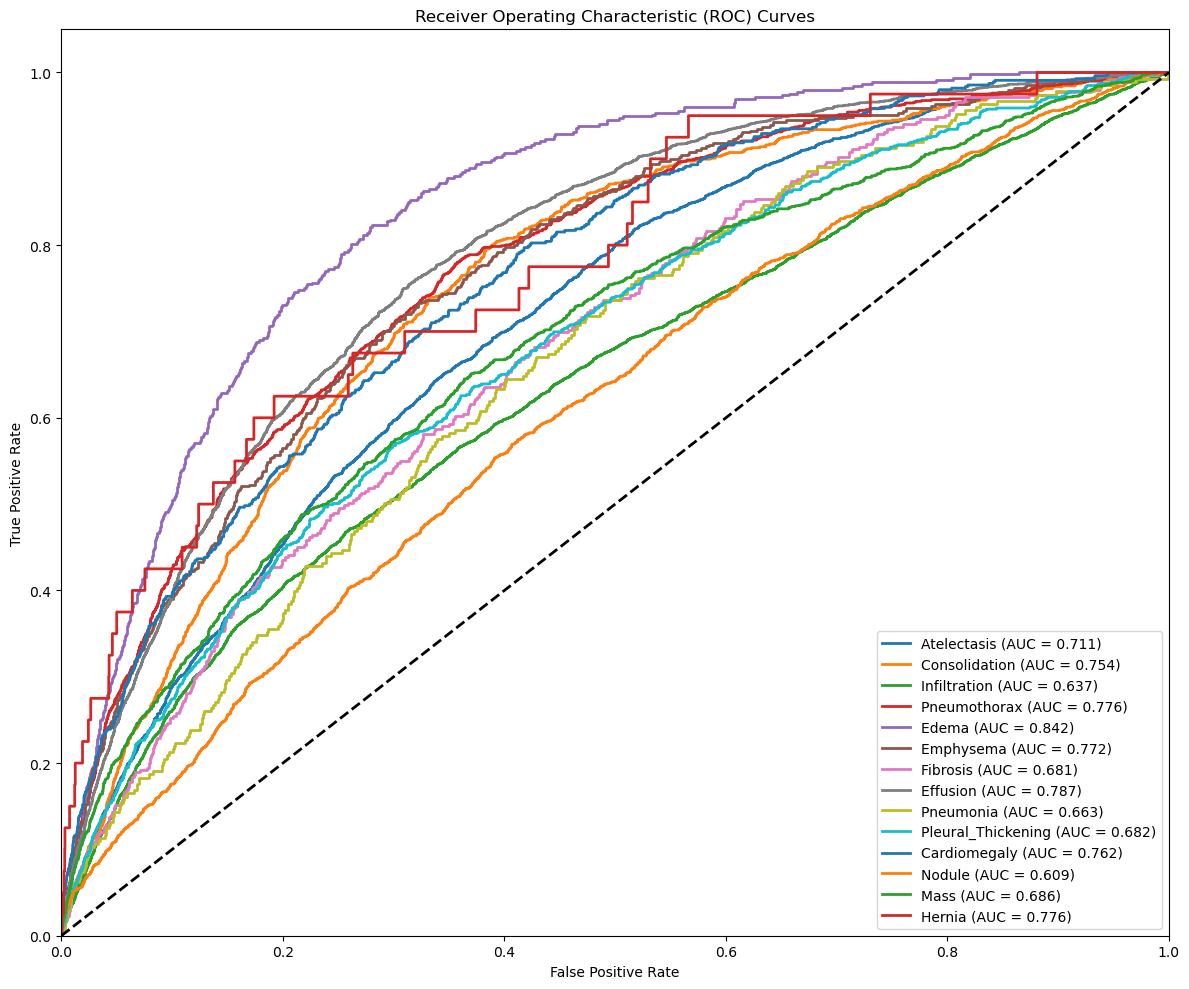

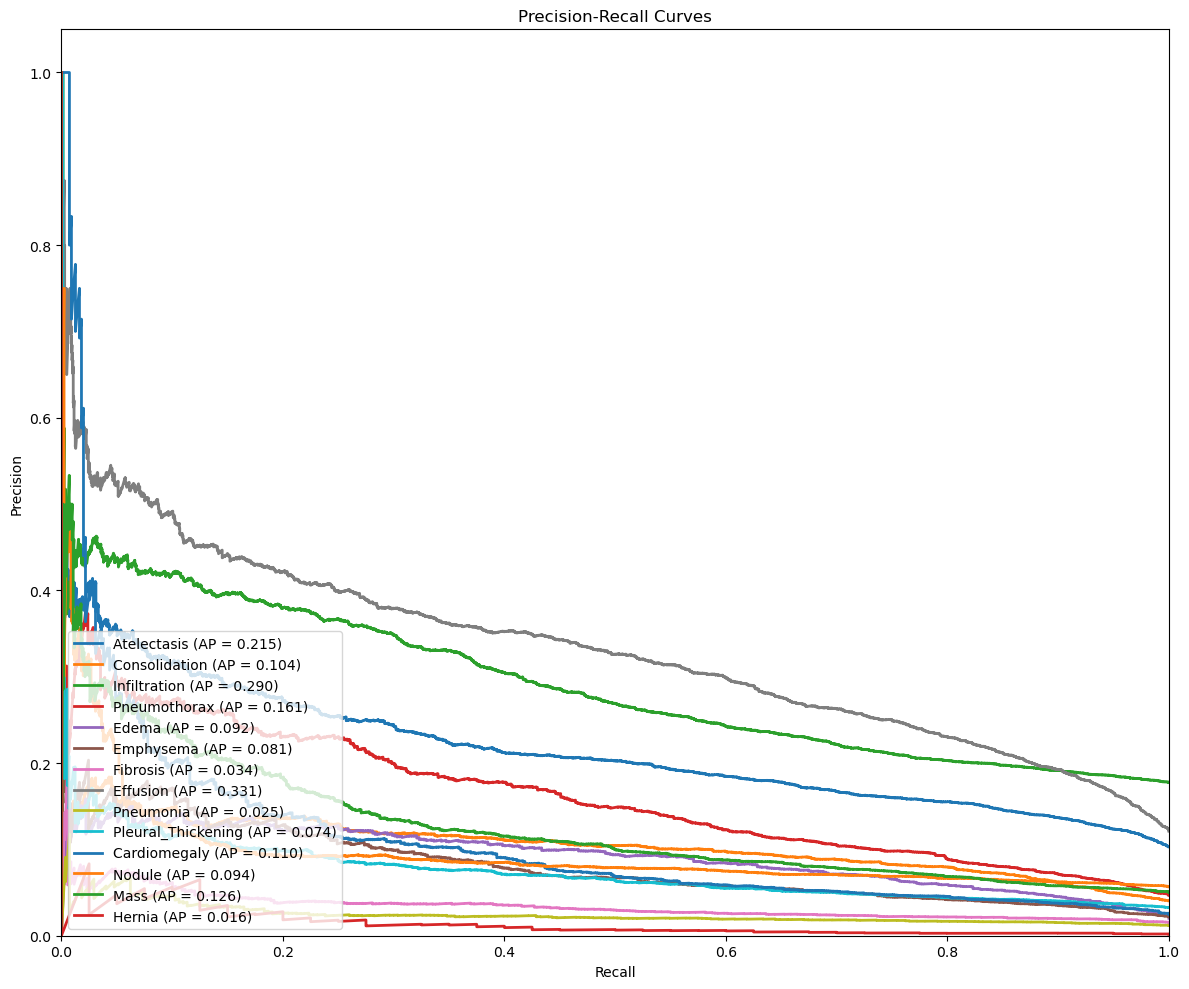

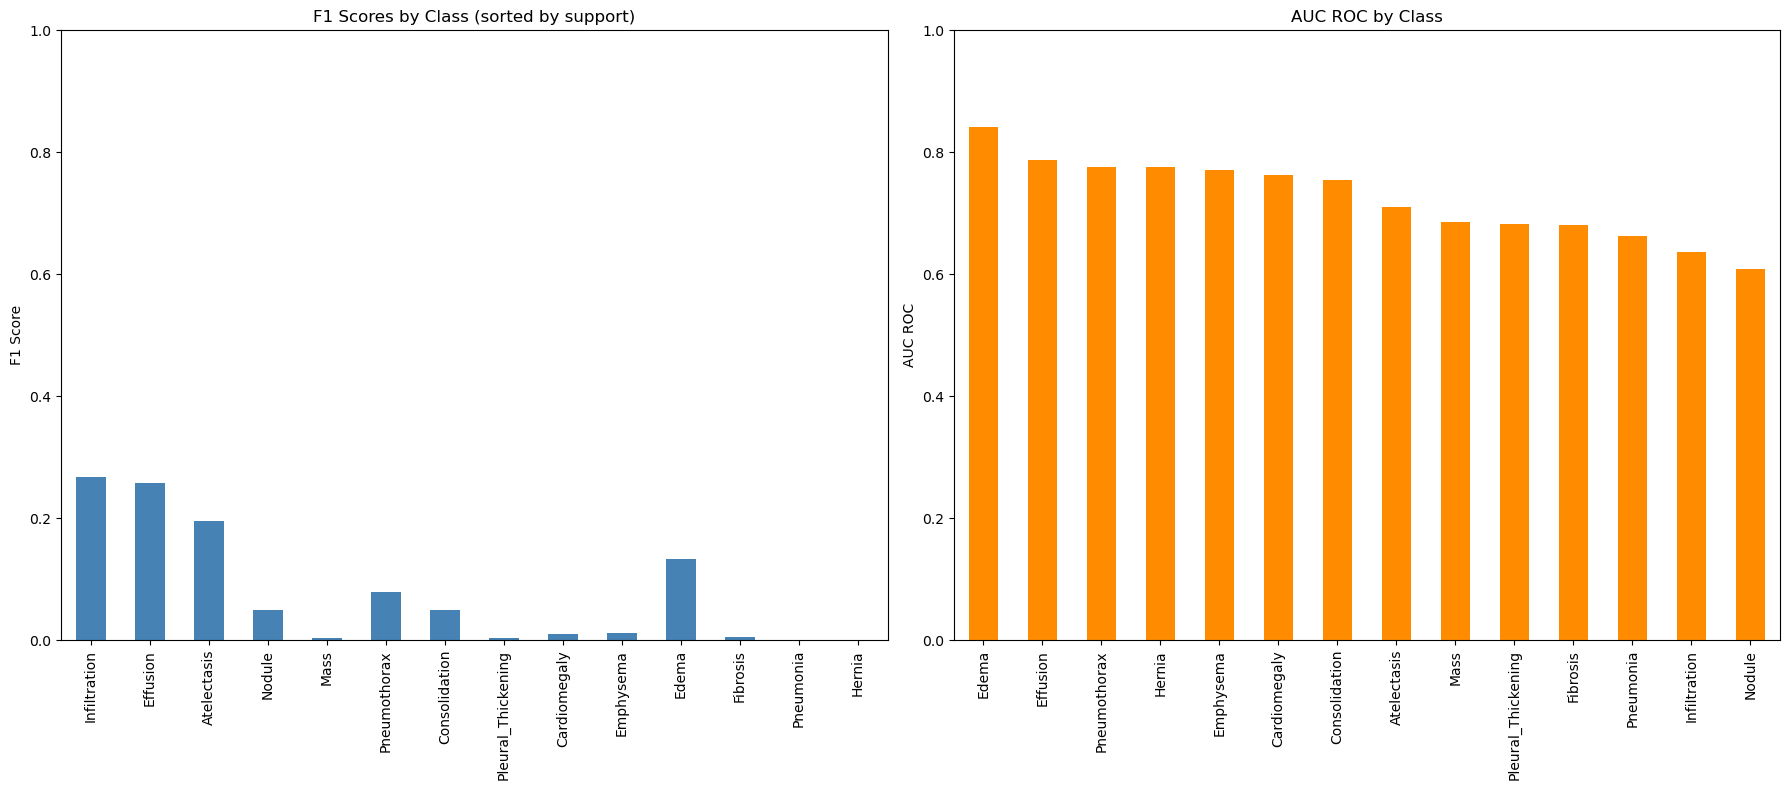

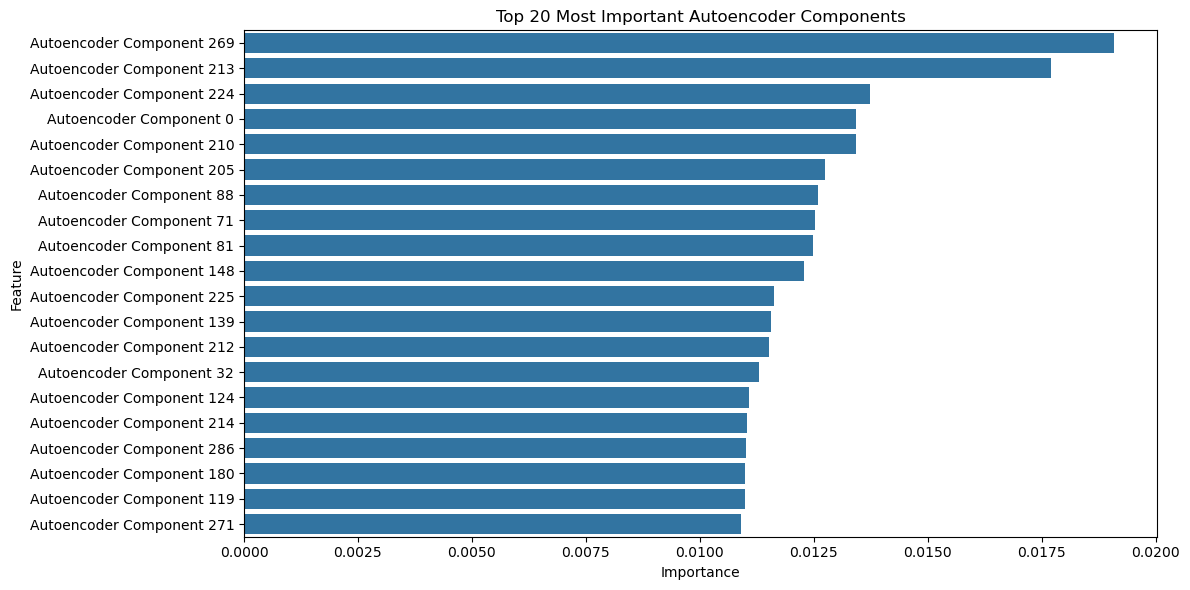

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, hamming_loss, jaccard_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.utils import shuffle

# Load the data
csv_file = "xray_input.csv"
df = pd.read_csv(csv_file)

# Define columns
label_cols = [
    "Atelectasis", "Consolidation", "Infiltration", "Pneumothorax", "Edema",
    "Emphysema", "Fibrosis", "Effusion", "Pneumonia", "Pleural_Thickening",
    "Cardiomegaly", "Nodule", "Mass", "Hernia"
]

# Create a list of the x-columns (features)
x_cols = [col for col in df.columns if col.startswith("x")]

# Separate features and labels
X = df[x_cols]
y = df[label_cols]

# Create a column indicating if all labels are 0 (no findings)
y['no_finding'] = (y.sum(axis=1) == 0).astype(int)

# Split the data first to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y.drop('no_finding', axis=1),
    test_size=0.2,
    random_state=42,
    stratify=y['no_finding']
)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

# Scale the data before applying dimensionality reduction
print("Scaling data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim=2048, encoding_dim=100):
        super(Autoencoder, self).__init__()
        # Encoder: reduces dimensionality
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim),
            nn.ReLU()
        )
        # Decoder: reconstructs the input from the encoded representation
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()  # Using Sigmoid for normalized data
        )
       
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Set hyperparameters
input_dim = X_train_scaled.shape[1]  # Number of features
encoding_dim = 300  # Same dimension as your PCA to make comparison fair
batch_size = 128
num_epochs = 30  # Increase for better convergence

print(f"Training autoencoder with encoding dimension {encoding_dim}...")

# Initialize the model
model = Autoencoder(input_dim, encoding_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Create PyTorch datasets and dataloaders
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        # Get the inputs
        inputs = batch[0]
        
        # Forward pass
        outputs, _ = model(inputs)
        loss = criterion(outputs, inputs)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.6f}")

# Set model to evaluation mode
model.eval()

# Generate encodings for train and test sets
with torch.no_grad():
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    _, X_train_encoded = model(X_train_tensor)
    X_train_encoded = X_train_encoded.numpy()
    
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    _, X_test_encoded = model(X_test_tensor)
    X_test_encoded = X_test_encoded.numpy()

print(f"Encoded training data shape: {X_train_encoded.shape}")
print(f"Encoded test data shape: {X_test_encoded.shape}")

# Calculate reconstruction error to verify autoencoder performance
with torch.no_grad():
    reconstructed, _ = model(X_test_tensor)
    reconstruction_error = criterion(reconstructed, X_test_tensor).item()
    print(f"Test set reconstruction error: {reconstruction_error:.6f}")

# Handle class imbalance by sampling
print("\nHandling class imbalance...")
no_findings = y_train.sum(axis=1) == 0
X_train_no_findings = X_train_encoded[no_findings]
y_train_no_findings = y_train[no_findings]
X_train_findings = X_train_encoded[~no_findings]
y_train_findings = y_train[~no_findings]

# Sample only a portion of the no-findings records
sample_size = int(len(X_train_no_findings) * 0.20)  # Adjust ratio as needed
print(f"Sampling {sample_size} from {len(X_train_no_findings)} no-findings cases")
indices = np.random.choice(len(X_train_no_findings), sample_size, replace=False)
X_train_no_findings_sampled = X_train_no_findings[indices]
y_train_no_findings_sampled = y_train_no_findings.iloc[indices]

# Combine the sampled no-findings with all findings samples
X_train_balanced = np.vstack([X_train_no_findings_sampled, X_train_findings])
y_train_balanced = pd.concat([y_train_no_findings_sampled, y_train_findings])

# Shuffle the balanced data
X_train_balanced, y_train_balanced = shuffle(
    X_train_balanced, y_train_balanced, random_state=42
)

print(f"Balanced training data shape: {X_train_balanced.shape}")
print(f"Class distribution in balanced training data:")
for col in y_train_balanced.columns:
    count = y_train_balanced[col].sum()
    print(f"{col}: {count} positive cases ({count/len(y_train_balanced)*100:.2f}%)")

# Improved Random Forest classifier with parameters tuned to emphasize positive predictions
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced_subsample',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

# Define a function to train, predict and evaluate the model with AUC metrics
def train_evaluate_rf(clf, X_train, y_train, X_test, y_test):
    start_time = time.time()
    
    print("\nTraining Random Forest...")
    multi_clf = MultiOutputClassifier(clf, n_jobs=-1)
    multi_clf.fit(X_train, y_train)
    print(f"Random Forest training completed in {time.time() - start_time:.2f} seconds!")
    
    # Get both hard predictions and probability scores
    print("Generating predictions...")
    y_pred = multi_clf.predict(X_test)
    y_pred_proba = np.array([estimator.predict_proba(X_test)[:,1] for estimator in multi_clf.estimators_]).T
    
    # Evaluate
    print("\nEvaluation metrics for Random Forest:")
    print("-" * 50)
    
    # Convert test data to array format if needed
    y_test_array = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
    
    # Multi-label metrics
    hamming = hamming_loss(y_test_array, y_pred)
    jaccard = jaccard_score(y_test_array, y_pred, average='samples')
    
    print(f"Hamming Loss: {hamming:.4f} (lower is better)")
    print(f"Jaccard Score: {jaccard:.4f} (higher is better)")
    
    # Per-class metrics including AUC
    class_metrics = {}
    auc_scores = []
    ap_scores = []
    
    # Create figures for ROC curves and PR curves
    fig_roc, ax_roc = plt.subplots(figsize=(12, 10))
    fig_pr, ax_pr = plt.subplots(figsize=(12, 10))
    
    for i, label in enumerate(y_test.columns):
        print(f"\nClassification report for {label}:")
        report = classification_report(y_test_array[:, i], y_pred[:, i], zero_division=0, output_dict=True)
        print(classification_report(y_test_array[:, i], y_pred[:, i], zero_division=0))
        
        # Calculate AUC
        fpr, tpr, _ = roc_curve(y_test_array[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        
        # Calculate Average Precision
        precision, recall, _ = precision_recall_curve(y_test_array[:, i], y_pred_proba[:, i])
        avg_precision = average_precision_score(y_test_array[:, i], y_pred_proba[:, i])
        ap_scores.append(avg_precision)
        
        print(f"AUC ROC: {roc_auc:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        
        # Plot ROC curve
        ax_roc.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.3f})')
        
        # Plot PR curve
        ax_pr.plot(recall, precision, lw=2, label=f'{label} (AP = {avg_precision:.3f})')
        
        # Store metrics for this class
        if '1' in report:  # Check if we have metrics for the positive class
            class_metrics[label] = {
                'precision': report['1']['precision'],
                'recall': report['1']['recall'],
                'f1-score': report['1']['f1-score'],
                'support': report['1']['support'],
                'auc': roc_auc,
                'avg_precision': avg_precision
            }
        else:
            class_metrics[label] = {
                'precision': 0,
                'recall': 0,
                'f1-score': 0,
                'support': sum(y_test_array[:, i] == 1),
                'auc': roc_auc,
                'avg_precision': avg_precision
            }
    
    # Finalize ROC plot
    ax_roc.plot([0, 1], [0, 1], 'k--', lw=2)
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('Receiver Operating Characteristic (ROC) Curves')
    ax_roc.legend(loc="lower right")
    fig_roc.tight_layout()
    fig_roc.savefig('roc_curves_autoencoder.png')
    
    # Finalize PR plot
    ax_pr.set_xlim([0.0, 1.0])
    ax_pr.set_ylim([0.0, 1.05])
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title('Precision-Recall Curves')
    ax_pr.legend(loc="lower left")
    fig_pr.tight_layout()
    fig_pr.savefig('pr_curves_autoencoder.png')
    
    # Overall metrics for positive cases
    correct_positives = 0
    total_positives = 0
    false_positives = 0
    
    for i in range(len(y_test_array)):
        true_positives_in_example = np.logical_and(y_test_array[i] == 1, y_pred[i] == 1).sum()
        total_positives_in_example = (y_test_array[i] == 1).sum()
        false_positives_in_example = np.logical_and(y_test_array[i] == 0, y_pred[i] == 1).sum()
        
        correct_positives += true_positives_in_example
        total_positives += total_positives_in_example
        false_positives += false_positives_in_example
    
    positive_recall = correct_positives / total_positives if total_positives > 0 else 0
    positive_precision = correct_positives / (correct_positives + false_positives) if (correct_positives + false_positives) > 0 else 0
    positive_f1 = 2 * (positive_precision * positive_recall) / (positive_precision + positive_recall) if (positive_precision + positive_recall) > 0 else 0
    
    print("\nOverall metrics for positive classes:")
    print(f"Overall positive recall: {positive_recall:.4f}")
    print(f"Overall positive precision: {positive_precision:.4f}")
    print(f"Overall positive F1 score: {positive_f1:.4f}")
    print(f"Mean AUC ROC: {np.mean(auc_scores):.4f}")
    print(f"Mean Average Precision: {np.mean(ap_scores):.4f}")
    
    # Count examples with at least one positive prediction
    examples_with_positives = np.sum(np.any(y_test_array == 1, axis=1))
    examples_with_correct_positives = 0
    
    for i in range(len(y_test_array)):
        if np.any(y_test_array[i] == 1) and np.any(np.logical_and(y_test_array[i] == 1, y_pred[i] == 1)):
            examples_with_correct_positives += 1
    
    print(f"\nExamples with at least one positive label: {examples_with_positives}")
    print(f"Examples with at least one correctly predicted positive: {examples_with_correct_positives}")
    
    if examples_with_positives > 0:
        positive_example_accuracy = examples_with_correct_positives / examples_with_positives
        print(f"Percentage of positive examples with at least one correct prediction: {positive_example_accuracy:.4f}")
    else:
        positive_example_accuracy = 0
    
    # Calculate class thresholds for optimal F1 score
    print("\nFinding optimal thresholds for each class to maximize F1 score:")
    optimal_thresholds = {}
    
    for i, label in enumerate(y_test.columns):
        best_threshold = 0.5  # Default
        best_f1 = 0
        
        # Try different thresholds
        for threshold in np.arange(0.1, 0.9, 0.05):
            y_pred_at_threshold = (y_pred_proba[:, i] >= threshold).astype(int)
            
            # Calculate F1 at this threshold
            precision = np.sum((y_test_array[:, i] == 1) & (y_pred_at_threshold == 1)) / np.sum(y_pred_at_threshold == 1) if np.sum(y_pred_at_threshold == 1) > 0 else 0
            recall = np.sum((y_test_array[:, i] == 1) & (y_pred_at_threshold == 1)) / np.sum(y_test_array[:, i] == 1) if np.sum(y_test_array[:, i] == 1) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        optimal_thresholds[label] = {
            'threshold': best_threshold,
            'f1_at_threshold': best_f1
        }
        print(f"{label}: Optimal threshold = {best_threshold:.2f}, F1 score = {best_f1:.4f}")
    
    # Create dataframe for class metrics
    metrics_df = pd.DataFrame(class_metrics).T
    
    # Sort by AUC descending to see which conditions are most predictable
    metrics_df = metrics_df.sort_values('auc', ascending=False)
    
    # Plot class metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot F1 scores
    metrics_df.sort_values('support', ascending=False)['f1-score'].plot(kind='bar', ax=ax1, color='steelblue')
    ax1.set_title('F1 Scores by Class (sorted by support)')
    ax1.set_ylabel('F1 Score')
    ax1.set_ylim([0, 1])
    
    # Plot AUC scores
    metrics_df['auc'].plot(kind='bar', ax=ax2, color='darkorange')
    ax2.set_title('AUC ROC by Class')
    ax2.set_ylabel('AUC ROC')
    ax2.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('class_metrics_autoencoder.png')
    
    # Save metrics in a dictionary for potential future use
    metrics = {
        "hamming_loss": hamming,
        "jaccard_score": jaccard,
        "positive_recall": positive_recall,
        "positive_precision": positive_precision,
        "positive_f1": positive_f1,
        "positive_example_accuracy": positive_example_accuracy,
        "mean_auc": np.mean(auc_scores),
        "mean_ap": np.mean(ap_scores),
        "class_metrics": class_metrics,
        "optimal_thresholds": optimal_thresholds
    }
    
    return multi_clf, metrics, y_pred_proba

# Train and evaluate the Random Forest model
rf_model, rf_metrics, rf_probas = train_evaluate_rf(
    rf_classifier, 
    X_train_balanced, y_train_balanced, 
    X_test_encoded, y_test
)

# Feature importance analysis
print("\nAnalyzing feature importance...")
feature_importances = np.zeros(X_train_balanced.shape[1])
for i, estimator in enumerate(rf_model.estimators_):
    feature_importances += estimator.feature_importances_

feature_importances /= len(rf_model.estimators_)

# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': [f'Autoencoder Component {i}' for i in range(X_train_balanced.shape[1])],
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Most Important Autoencoder Components')
plt.tight_layout()
plt.savefig('feature_importance_autoencoder.png')

# Apply optimal thresholds to get predictions that better emphasize positive cases
print("\nApplying optimal thresholds to improve positive case prediction...")
optimized_predictions = np.zeros_like(y_test.values)

for i, label in enumerate(y_test.columns):
    threshold = rf_metrics['optimal_thresholds'][label]['threshold']
    optimized_predictions[:, i] = (rf_probas[:, i] >= threshold).astype(int)

# Calculate metrics with optimized thresholds
optimized_recall = np.sum(np.logical_and(y_test.values == 1, optimized_predictions == 1)) / np.sum(y_test.values == 1)
optimized_precision = np.sum(np.logical_and(y_test.values == 1, optimized_predictions == 1)) / np.sum(optimized_predictions == 1)
optimized_f1 = 2 * (optimized_precision * optimized_recall) / (optimized_precision + optimized_recall) if (optimized_precision + optimized_recall) > 0 else 0

print(f"Metrics with optimized thresholds:")
print(f"Optimized positive recall: {optimized_recall:.4f}")
print(f"Optimized positive precision: {optimized_precision:.4f}")
print(f"Optimized positive F1 score: {optimized_f1:.4f}")
